# EE 353

# Assignment 2 : Linear Models and Regularization

<p float="right">Pranav Prakash - 22B3945<p>

[Link to submission video](https://drive.google.com/drive/folders/17RDCQzL_IkmWA2indw4i4zeZLaaYjuvI?usp=sharing)

Disclosure:  
Comments and docstrings added by _[0]_  
Test cases generated by _[2]_

We start off by importing all the libraries used going forward (these have been moved up into one place).

- `matplotlib` and `seaborn` are libraries used to render graphical data plots and other representations:
  - `matplotlib.pyplot`: This is a versatile plotting library used to create static, animated, and interactive visualizations in Python. It is often used for creating line plots, histograms, scatter plots, and more, giving us fine-grained control over the layout and style of the plots.
  - `seaborn`: Seaborn is built on top of `matplotlib` and provides a higher-level interface for drawing attractive and informative statistical graphics. It simplifies the creation of complex visualizations like heatmaps, violin plots, and pair plots while enhancing visual appeal with better aesthetics and themes.

- **`numpy`**: This library is used for numerical computations and is essential for handling arrays and performing operations on them efficiently. In data analysis, NumPy is particularly useful for mathematical operations, data manipulation, and working with large datasets due to its speed and functionality.

- **`time`**: This module provides various time-related functions. In our assignment, it is used to measure execution time, helping us identify performance bottlenecks in our code.

- **`collections.deque`**: The deque (double-ended queue) is a data structure that allows for fast appends and pops from both ends. It is used to maintain a fixed-length history of data points, enabling efficient management of recent observations in our analysis.

*Generated via AI : [1]*


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from collections import deque

## 1
> _Write a function to generate an input data matrix X of size NxD for regression._

In [33]:
def generate_input_matrix(N, M, D, S, seed=None):
    """
    Generate a data matrix X of size NxD for regression.
    
    Parameters
    ----------
    N : int
        Sample size (number of rows).
    M : int
        Number of features in the random matrix.
    D : int
        Number of features in the final output matrix.
    S : numpy.ndarray
        Generator matrix of size MxD.
    seed : int, optional
        Seed for the random number generator to allow for reproducability, by default None.

    Returns
    -------
    X : numpy.ndarray
        Output matrix of size NxD.
    """

    if isinstance(seed, int):
        np.random.seed(seed)

    # Step 1: Generate a random matrix of size NxM with standard normal distribution
    Z = np.random.randn(N, M)
    
    # Step 2: Multiply the random matrix with the generator matrix S of size MxD
    X = np.dot(Z, S)
    
    return X

#### Test

In [34]:
# Generated by [2]
def test_generate_input_matrix():
    """
    Test case for generate_input_matrix function.
    """
    # Test parameters
    N = 1000  # Number of samples
    M = 5    # Number of features in the random matrix
    D = 3    # Number of features in the final matrix
    S = np.eye(M, D)  # Generator matrix, an identity matrix for independent features
    correlation_threshold = 0.1 if N < 2000 else 0.05  # Set a threshold for maximum allowed correlation

    # Test 1: Same seed should produce the same output
    seed = 42
    X1 = generate_input_matrix(N, M, D, S, seed=seed)
    X2 = generate_input_matrix(N, M, D, S, seed=seed)
    
    assert np.array_equal(X1, X2), "Test 1 Failed: Outputs with the same seed should be identical."

    # Test 2: Different seeds should produce different outputs
    seed1 = 42
    seed2 = 99
    X1 = generate_input_matrix(N, M, D, S, seed=seed1)
    X2 = generate_input_matrix(N, M, D, S, seed=seed2)

    assert not np.array_equal(X1, X2), "Test 2 Failed: Outputs with different seeds should not be identical."

    # Test 3: Resetting the seed should produce the same output
    seed = 42
    np.random.seed(seed)  # Reset the seed
    X3 = generate_input_matrix(N, M, D, S, seed=seed)
    
    np.random.seed(seed)  # Reset the seed again
    X4 = generate_input_matrix(N, M, D, S, seed=seed)

    assert np.array_equal(X3, X4), "Test 3 Failed: Outputs with the same seed after resetting should be identical."

    # Generate the input matrix
    X = generate_input_matrix(N, M, D, S)

    # Check the shape of the output matrix
    assert X.shape == (N, D), f"Expected shape {(N, D)}, but got {X.shape}"

    # Calculate the correlation matrix between columns of X
    corr_matrix = np.corrcoef(X.T)  # Compute the correlation between columns
    max_corr_value = np.max(np.abs(corr_matrix - np.eye(D)))  # Exclude diagonal (self-correlation)

    # Check if the max correlation exceeds the threshold
    assert max_corr_value <= correlation_threshold, f"Max correlation {max_corr_value:.3f} exceeds threshold {correlation_threshold:.3f}"

    print("All test cases passed!")

# Run the test case
test_generate_input_matrix()

All test cases passed!


## 2
> _Write a function to generate the target vector t of size Nx1_

In [35]:
def generate_target_vector(X, w, sigma):
    """
    Generate a target vector t of size Nx1 for regression.
    
    Parameters
    ----------
    X : numpy.ndarray
        Data matrix of size NxD.
    w : numpy.ndarray
        Weight vector of size D+1 (includes bias term) in 1D or 2D.
    sigma : float
        Noise variance for adding Gaussian noise.
    
    Returns
    -------
    t : numpy.ndarray
        Target vector of size Nx1.
    """
    N, D = X.shape  # Get the shape of X
    
    # Flatten the weights in case a 2D array is provided
    w = w.flatten()  # Ensure w is a 1D array

    # Check for dimension mismatch between X and w
    if len(w) != D + 1:
        raise ValueError(f"Dimension mismatch: X has {D} columns, but w has {len(w)} elements. w should have {D + 1} elements.")
    
    # Separate bias (the first element of w) and weights (remaining elements)
    bias = w[0]
    weights = w[1:]

    # Multiply X with the weight vector (sans the bias) to get a 1D array
    t = np.dot(X, weights) + bias  # This will be a 1D array of size N

    # Add zero-mean Gaussian noise with variance sigma
    noise = np.random.normal(0, np.sqrt(sigma), size=N)  # Noise is 1D with size N
    t += noise  # Add noise to the target vector

    return t.reshape(-1, 1)  # Reshape to Nx1 vector


#### Test

In [36]:
def test_generate_target_vector():
    """
    Test case for generate_target_vector function.
    """
    # Test parameters
    N = 1000  # Number of samples
    D = 3    # Number of features in the data matrix
    X = np.random.randn(N, D)  # Random data matrix
    w = np.array([2.0, 1.5, -0.5, 0.8])  # Weight vector (D+1 elements, including bias)
    sigma = 0.1  # Noise variance
    
    # Generate the target vector
    t = generate_target_vector(X, w, sigma)
    
    # Check the shape of the target vector
    assert t.shape == (N, 1), f"Expected shape {(N, 1)}, but got {t.shape}"
    
    # Verify that the target values without noise match the linear transformation (X * w[1:] + w[0])
    t_without_noise = np.dot(X, w[1:]) + w[0]
    
    # Calculate the noise added
    noise = t.flatten() - t_without_noise
    
    # Check if the noise has approximately zero mean
    assert np.abs(np.mean(noise)) < 3e-2, f"Expected noise mean close to 0, but got {np.mean(noise)}"
    
    # Check if the noise has approximately the specified variance
    estimated_variance = np.var(noise)
    assert np.abs(estimated_variance - sigma) < 1e-2, f"Expected noise variance close to {sigma}, but got {estimated_variance}"

    print("All test cases passed!")

# Run the test case
test_generate_target_vector()


All test cases passed!


## 3
> _Examine the behavior of the analytical solver based on pseudo-inverse (pinv) in numpy.linalg package with respect to the size of the data matrix. Plot a graph of the time taken with respect to N (use log scale for both axes), with D fixed to 10. Is there any strange behavior in time taken to solve the problem above a particular value of N? What could be the reason for the same?_

[0.00020990371704101562, 0.00019097328186035156, 0.0, 0.0, 0.0, 0.0032979488372802735, 0.004097270965576172, 0.0058362483978271484, 0.011098098754882813, 0.030213356018066406, 0.1290602684020996, 0.38871421813964846, 1.2212558746337892, 3.4932689666748047]


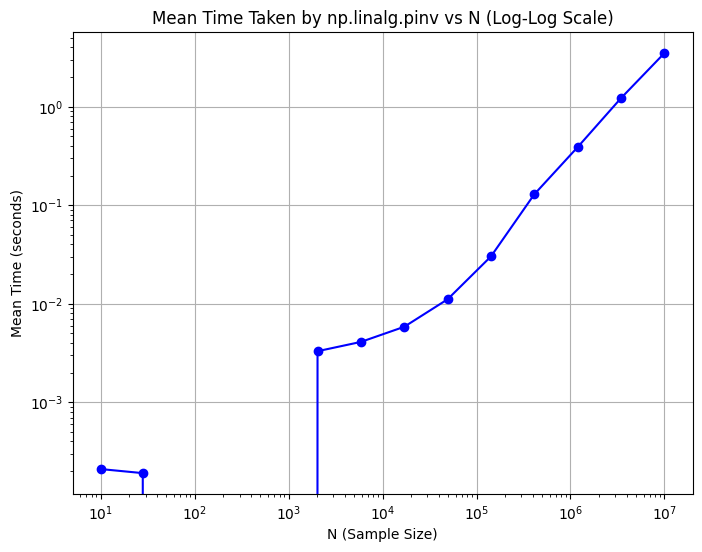

In [37]:
# Generate N_values dynamically using logspace, generated by [3]
final_order = 7  # This defines the final value as 10^final_order (i.e., 10^6 = 1000000)
num_points_per_order = 2  # Number of points between each order of magnitude
N_values = np.logspace(1, final_order, num=(final_order * num_points_per_order), dtype=int)  # Generate values from 10^1 to 10^final_order

D = 10  # Fixed number of features
num_runs = 5  # Number of runs to average the timing

times = []

# Measure the time taken by np.linalg.pinv for each N
for N in N_values:
    elapsed_times = []
    
    for _ in range(num_runs):
        # Generate a random matrix of size NxD
        X = np.random.randn(N, D)
        
        # Measure the time taken to compute the pseudo-inverse
        start_time = time.time()
        np.linalg.pinv(X)
        elapsed_time = time.time() - start_time
        elapsed_times.append(elapsed_time)
    
    # Take the mean of the times across multiple runs
    mean_time = np.mean(elapsed_times)
    times.append(mean_time)

print(times)

# Plot the results (log-log scale)
plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.plot(N_values, times, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N (Sample Size)')
plt.ylabel('Mean Time (seconds)')
plt.title('Mean Time Taken by np.linalg.pinv vs N (Log-Log Scale)')
plt.grid(True)
plt.show()


Quite clearly, there seems to be a sudden jump around numbers to the order of $10^3$, after which the time taken seems to adopt a linear relation in relation to `N`.

This could probably be due to exhaustion of CPU resources, that leads to values above a certain limit not fitting within fast access registers/memory.

## 4
> _Write a function to calculate the normalized root mean squared error (NRMSE) between a target vector t and a predicted vector y._

In [38]:
def calculate_nrmse(t, y):
    """
    Calculate the normalized root mean squared error (NRMSE) between target vector t and predicted vector y.
    
    Parameters
    ----------
    t : numpy.ndarray
        Target vector of size Nx1.
    y : numpy.ndarray
        Predicted vector of size Nx1.
    
    Returns
    -------
    nrmse : float
        The normalized root mean squared error.
    """
    # Ensure t and y have the same shape
    if t.shape != y.shape:
        raise ValueError(f"Dimension mismatch: t has shape {t.shape}, but y has shape {y.shape}.")
    
    # Calculate the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean((t - y) ** 2))
    
    # Calculate the normalization factor (standard deviation of t)
    t_std = np.std(t)

    # Avoid division by zero if t_std is zero
    if t_std == 0:
        raise ValueError("The standard deviation of the target vector t is zero, which would cause division by zero in NRMSE.")
    
    # Calculate and return NRMSE
    nrmse = rmse / t_std
    return nrmse



#### Test

In [39]:
def test_calculate_nrmse():
    """
    Test case for the calculate_nrmse function.
    """
    # Test 1: Perfect prediction (NRMSE should be 0)
    t = np.array([[2.0], [4.0], [6.0], [8.0]])
    y = np.array([[2.0], [4.0], [6.0], [8.0]])  # Perfect prediction
    nrmse = calculate_nrmse(t, y)
    assert np.isclose(nrmse, 0.0), f"Expected NRMSE = 0.0, but got {nrmse}"
    
    # Test 2: Some prediction error
    t = np.array([[1.0], [2.0], [3.0], [4.0]])
    y = np.array([[1.1], [2.1], [2.9], [3.8]])  # Slight errors in prediction
    nrmse = calculate_nrmse(t, y)
    expected_nrmse = np.sqrt(np.mean((t - y) ** 2)) / np.std(t)  # Updated calculation
    assert np.isclose(nrmse, expected_nrmse), f"Expected NRMSE = {expected_nrmse}, but got {nrmse}"
    
    # Test 3: Large prediction error
    t = np.array([[10.0], [20.0], [30.0], [40.0]])
    y = np.array([[15.0], [25.0], [35.0], [45.0]])  # Larger errors
    nrmse = calculate_nrmse(t, y)
    expected_nrmse = np.sqrt(np.mean((t - y) ** 2)) / np.std(t)  # Updated calculation
    assert np.isclose(nrmse, expected_nrmse), f"Expected NRMSE = {expected_nrmse}, but got {nrmse}"

    # Test 4: t and y of different dimensions (should raise an error)
    t = np.array([[1.0], [2.0], [3.0], [4.0]])
    y = np.array([[1.0], [2.0], [3.0]])  # Dimension mismatch
    try:
        calculate_nrmse(t, y)
        assert False, "Expected ValueError due to dimension mismatch, but no error was raised."
    except ValueError as e:
        assert str(e) == f"Dimension mismatch: t has shape {t.shape}, but y has shape {y.shape}."

    # Test 5: t with zero standard deviation (should raise an error)
    t = np.array([[3.0], [3.0], [3.0], [3.0]])  # All elements are the same, std = 0
    y = np.array([[2.0], [2.0], [2.0], [2.0]])  # Different predictions
    try:
        calculate_nrmse(t, y)
        assert False, "Expected ValueError due to zero standard deviation of t, but no error was raised."
    except ValueError as e:
        assert str(e) == "The standard deviation of the target vector t is zero, which would cause division by zero in NRMSE."
    
    print("All test cases passed!")

# Run the test function
test_calculate_nrmse()


All test cases passed!


## 5
> _Write a function to calculate gradient of mean squared error (MSE) with respect to weights of linear regression. Figure out what should be the inputs and outputs._

In [40]:
def mse_gradient(X, t, w):
    """
    Calculate the gradient of the Mean Squared Error (MSE) with respect to weights.
    
    Parameters
    ----------
    X : numpy.ndarray
        Data matrix of size NxD (N samples, D features).
    t : numpy.ndarray
        Target vector of size Nx1.
    w : numpy.ndarray
        Weight vector of size (D+1)x1 (includes bias).
    
    Returns
    -------
    grad : numpy.ndarray
        Gradient of the MSE with respect to the weights (size (D+1)x1, includes bias).
    """
    N = X.shape[0]  # Number of samples
    
    # Add a column of ones to X for the bias term
    X_augmented = np.hstack([np.ones((N, 1)), X])  # Augment X with a column of ones
    
    # Compute the predicted values y = X_augmented * w
    y = np.dot(X_augmented, w)
    
    # Compute the gradient of MSE
    grad = (2 / N) * np.dot(X_augmented.T, (y - t))
    
    return grad


#### Test

In [41]:
def test_mse_gradient_with_bias():
    """
    Test case for mse_gradient function.
    """
    # Test 1: Small data
    X = np.array([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])  # NxD
    t = np.array([[7.0], [8.0], [9.0]])  # Target vector Nx1
    w = np.array([[0.5], [0.5], [0.5]])  # Weight vector (D+1)x1 (including bias)
    
    grad = mse_gradient(X, t, w)
    
    # Manually calculate the expected gradient
    X_augmented = np.hstack([np.ones((X.shape[0], 1)), X])  # Add a column of ones for bias
    y = np.dot(X_augmented, w)  # Predicted values
    expected_grad = (2 / X.shape[0]) * np.dot(X_augmented.T, (y - t))
    
    assert np.allclose(grad, expected_grad), f"Expected {expected_grad}, but got {grad}"
    
    print("Test passed for gradient with bias!")

# Run the test function
test_mse_gradient_with_bias()


Test passed for gradient with bias!


## 6
> _Write a function to calculate gradient of L2 norm of weights with respect to weights._

In [42]:
def l2_gradient(w):
    """
    Calculate the gradient of the L2 norm of weights with respect to the weights.
    
    Parameters
    ----------
    w : numpy.ndarray
        Weight vector of size (D+1)x1 (including bias at index 0).
    
    Returns
    -------
    grad : numpy.ndarray
        Gradient of the L2 norm with respect to the weights.
    """
    grad = 2 * w.copy()
    grad[0] = 0  # Do not regularize the bias term
    return grad

#### Test
_Trivial but kept in for the sake of keeping the format_

In [43]:
def test_l2_gradient():
    """
    Test case for l2_gradient function.
    """
    # Test 1: Simple case with a small weight vector (including bias)
    w = np.array([[1.0], [2.0], [3.0]])  # Bias is at index 0
    grad = l2_gradient(w)
    expected_grad = np.array([[0.0], [4.0], [6.0]])  # Bias is not regularized
    assert np.allclose(grad, expected_grad), f"Expected {expected_grad}, but got {grad}"
    
    # Test 2: Large random weight vector (with bias)
    w = np.random.randn(5, 1)  # Random weight vector, including bias
    grad = l2_gradient(w)
    expected_grad = 2* w.copy()
    expected_grad[0] = 0  # Bias is not regularized
    assert np.allclose(grad, expected_grad), f"Expected {expected_grad}, but got {grad}"

    # Test 3: Zero weight vector (gradient should be zero, including bias)
    w = np.zeros((3, 1))
    grad = l2_gradient(w)
    expected_grad = np.zeros((3, 1))
    assert np.allclose(grad, expected_grad), f"Expected {expected_grad}, but got {grad}"

    print("All test cases for L2 gradient passed!")

# Run the test function
test_l2_gradient()


All test cases for L2 gradient passed!


## 7
> _Write a function to calculate gradient of L1 norm of weights with respect to weights._

In [44]:
def l1_gradient(w):
    """
    Calculate the gradient of the L1 norm of weights with respect to the weights.
    
    Parameters
    ----------
    w : numpy.ndarray
        Weight vector of size (D+1)x1 (including bias at index 0).
    
    Returns
    -------
    grad : numpy.ndarray
        Gradient of the L1 norm with respect to the weights.
    """
    grad = np.sign(w)
    grad[0] = 0  # Do not regularize the bias term
    return grad

#### Test

In [45]:
def test_l1_gradient():
    """
    Test case for l1_gradient function.
    """
    # Test 1: Positive and negative values (including bias)
    w = np.array([[1.0], [-2.0], [3.0], [-4.0]])  # Bias is at index 0
    grad = l1_gradient(w)
    expected_grad = np.array([[0.0], [-1.0], [1.0], [-1.0]])  # Bias is not regularized
    assert np.allclose(grad, expected_grad), f"Expected {expected_grad}, but got {grad}"
    
    # Test 2: Zero weights (including bias, gradient should be 0)
    w = np.array([[0.0], [0.0], [0.0]])
    grad = l1_gradient(w)
    expected_grad = np.array([[0.0], [0.0], [0.0]])  # No regularization for bias
    assert np.allclose(grad, expected_grad), f"Expected {expected_grad}, but got {grad}"
    
    # Test 3: Random weights with both positive and negative values (including bias)
    w = np.random.randn(5, 1)  # Random weight vector, including bias
    grad = l1_gradient(w)
    expected_grad = np.sign(w)
    expected_grad[0] = 0  # Bias is not regularized
    assert np.allclose(grad, expected_grad), f"Expected {expected_grad}, but got {grad}"

    print("All test cases for L1 gradient passed!")

# Run the test function
test_l1_gradient()


All test cases for L1 gradient passed!


## 8
> _Write a function to perform gradient descent on MSE + $λ_1L_1$ +  $λ_2L_2$ for linear regression. Use an appropriate stopping criterion._

In [46]:
def gradient_descent(X, t, w_init, lambda_1, lambda_2, learning_rate=0.01, max_iter=1000, tol=1e-6, loss_queue_length=100, print_level=1):
    """
    Perform gradient descent to minimize MSE + λ1*L1 + λ2*L2 with bias handling.
    """
    w = w_init.copy()
    N, D = X.shape
    
    # Use deque to store a fixed number of recent losses, as suggested by [5]
    losses = deque(maxlen=loss_queue_length)

    for iteration in range(max_iter):
        # Compute the gradient of MSE
        mse_grad = mse_gradient(X, t, w)

        # Compute the gradients of L1 and L2 norms (bias is not regularized)
        l1_grad = lambda_1 * l1_gradient(w)
        l2_grad = lambda_2 * l2_gradient(w)

        # Combine the gradients
        total_grad = mse_grad + l1_grad + l2_grad

        # Update weights (bias should not be affected by regularization)
        w_new = w - learning_rate * total_grad

        # Compute predictions including bias (first term of w)
        y = np.dot(X, w[1:]) + w[0]

        # Compute the loss (MSE + λ1*L1 + λ2*L2, excluding bias from L1/L2 loss)
        mse_loss = np.mean((y - t) ** 2)
        l1_loss = lambda_1 * np.sum(np.abs(w[1:]))  # Exclude bias from L1 regularization
        l2_loss = lambda_2 * np.sum(w[1:] ** 2)    # Exclude bias from L2 regularization
        total_loss = mse_loss + l1_loss + l2_loss
        
        # Append the loss to the deque (automatically removes oldest entries if exceeding maxlen)
        losses.append(total_loss)


        # Generated by [4]
        # Stopping criterion: if the change in weights is smaller than the tolerance
        if np.linalg.norm(w_new - w) < tol:
            if print_level > 0: print(f"Convergence reached after {iteration+1} iterations.")
            break

        # Print the change in weights every 50 iterations
        if print_level > 1 and iteration % 50 == 0:
            print(f"Iteration {iteration}: Change in weights = {np.linalg.norm(w_new - w)}")

        w = w_new

    return w, losses


#### Test

In [47]:
def test_gradient_descent():
    """
    Test case for gradient_descent function using previously defined gradient functions.
    """
    # Test 1: Simple case with small data
    X = np.array([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])  # NxD
    t = np.array([[7.0], [8.0], [9.0]])  # Target vector Nx1
    w_init = np.zeros((3, 1))  # Initialize weights (including bias, hence D+1 size)
    lambda_1 = 0.1
    lambda_2 = 0.1
    learning_rate = 0.01
    loss_queue_length = 2000  # Large queue length to store all losses

    # Perform gradient descent
    w_final, losses = gradient_descent(X, t, w_init, lambda_1, lambda_2, learning_rate, max_iter=1000, loss_queue_length=loss_queue_length)

    # Verify dimension of final weights
    assert w_final.shape == w_init.shape, f"Expected weights of shape {w_init.shape}, but got {w_final.shape}"
    
    # Check that the length of the losses deque is as expected (max 2000)
    assert len(losses) <= loss_queue_length, f"Expected loss history length <= {loss_queue_length}, but got {len(losses)}"

    # Check the final loss is decreasing
    assert losses[-1] < losses[0], "Final loss should be smaller than initial loss"

    print("All test cases for gradient descent passed!")

# Run the test function
test_gradient_descent()


All test cases for gradient descent passed!


## Experimentation Function
This function has been created to help with all the following trend related questions.

Generated by [6]

In [64]:
def _generate_S(D, G):
    if isinstance(G, int):
        np.random.seed(G)
        return np.random.randn(D, D)
    elif isinstance(G, float):
        # Generated by [7]
        S = np.eye(D)
        np.random.seed(0)
        random_matrix = np.random.randn(D, D)  # Random values to introduce correlation

        for i in range(D):
            for j in range(D):
                if i != j:
                    S[i, j] = G * random_matrix[i, j]  # Introduce correlation based on the strength
        return S
    elif isinstance(G, np.ndarray):
        return G
    else:
        return np.eye(D)


def experiment(N=1000, D=10, sigma=1.0, w_true=None, lambda_1=0.01, lambda_2=0.01, learning_rate=0.01, max_iter=1000, num_runs=5, print_level=0, G=None, X_seed=None, custom_loss=None):
    """
    Perform the experiment to analyze the impact of hyper-parameters (including noise variance σ)
    and return the average weights and losses over multiple runs.
    
    Parameters
    ----------
    N : int, optional
        Number of samples. Default is 1000.
    D : int, optional
        Number of features. Default is 5.
    sigma : float, optional
        Noise variance. Default is 1.0.
    w_true : numpy.ndarray, optional
        True weight vector used to generate the target values. If None, a random vector is generated.
    lambda_1 : float, optional
        Regularization coefficient for L1 norm. Default is 0.01.
    lambda_2 : float, optional
        Regularization coefficient for L2 norm. Default is 0.01.
    learning_rate : float, optional
        Learning rate for gradient descent. Default is 0.01.
    max_iter : int, optional
        Maximum number of iterations. Default is 1000.
    num_runs : int, optional
        Number of experiment repetitions to average results. Default is 5.
    G : numpy.ndarray | int | float , optional
        Generator matrix for X. If None, an identity matrix is used. If integer, a random matrix is used with that seed. If float, a matrix is constructed with that correlation strength. Default is None.
    X_seed : int, optional
        Seed for generating the input matrix X. Default is None.
    print_level : int, optional
        Level of print output (0: no output, 1: minimal, 2: detailed). Default is 1.
    custom_loss : function, optional
        Custom loss function to use along with NRMSE. Default is None.
    
    Returns
    -------
    avg_loss : float
        Average loss over multiple runs.
    avg_weights : numpy.ndarray
        Averaged weight values over multiple runs.
    avg_custom_loss : float
        Average custom loss over multiple runs. Only returned if custom_loss is provided.
    """
    total_loss = 0
    total_custom_loss = 0
    total_weights = np.zeros((D+1, 1))  # Initialize averaged weights with size D+1 (including bias)
    train_size = int(0.8 * N)

    if w_true is None:
        w_true = np.random.randn(D + 1, 1)  # Generate a random weight vector with size D+1 (including bias)
    
    S = _generate_S(D, G)


    for _ in range(num_runs):
        # Generate random data matrix X and target vector t with noise variance sigma
        X = generate_input_matrix(N, D, D, S, seed=X_seed)
        t = generate_target_vector(X, w_true, sigma)

        if _ == 0 and print_level > 1:
            print(X[0,0], X[-1,-1])

        # Split into training and validation sets
        X_train, X_val = X[:train_size], X[train_size:]
        t_train, t_val = t[:train_size], t[train_size:]
        
        # Initialize weights (including bias, hence D+1 size)
        w_init = np.zeros((D+1, 1))
        
        # Train using gradient descent
        w_final, _ = gradient_descent(X_train, t_train, w_init, lambda_1, lambda_2, learning_rate, max_iter, print_level=print_level)
        
        # Predict on the validation set
        # Bias (w_final[0]) is added separately, weights (w_final[1:]) are used with X
        t_pred_val = np.dot(X_val, w_final[1:]) + w_final[0]
        
        # Calculate the final NRMSE as the loss on the validation set
        nrmse_val = calculate_nrmse(t_val, t_pred_val)
        total_loss += nrmse_val  # Sum the NRMSE loss over runs

        if custom_loss is not None:
            custom_loss_val = custom_loss(t_val, t_pred_val)
            total_custom_loss += custom_loss_val

        # Accumulate weights for averaging
        total_weights += w_final
    
    # Average loss and weights over num_runs
    avg_loss = total_loss / num_runs
    avg_weights = total_weights / num_runs
    
    if custom_loss is not None:
        avg_custom_loss = total_custom_loss / num_runs
        return avg_loss, avg_weights, avg_custom_loss
    
    return avg_loss, avg_weights


In [49]:
experiment(print_level=2)

-1.5206907288388842 -1.4074961764298397
Iteration 0: Change in weights = 0.05240417609981304
Iteration 50: Change in weights = 0.020311472137055493
Iteration 100: Change in weights = 0.008117589654298473
Iteration 150: Change in weights = 0.0033058320936019217
Iteration 200: Change in weights = 0.0013642906630051438
Iteration 250: Change in weights = 0.0005682088570222351
Iteration 300: Change in weights = 0.00023813122729134063
Iteration 350: Change in weights = 0.00010022287841755124
Iteration 400: Change in weights = 4.230364313304713e-05
Iteration 450: Change in weights = 1.789200506624153e-05
Iteration 500: Change in weights = 7.577887727798861e-06
Iteration 550: Change in weights = 3.212678854014715e-06
Iteration 600: Change in weights = 1.3629962551063136e-06
Convergence reached after 620 iterations.
Iteration 0: Change in weights = 0.06235229211729349
Iteration 50: Change in weights = 0.020592175418132994
Iteration 100: Change in weights = 0.007017018319904214
Iteration 150: Ch

(0.3313241144555704,
 array([[-0.52339135],
        [-1.065566  ],
        [-0.3753977 ],
        [ 0.30391777],
        [-1.02273176],
        [-1.56443418],
        [ 0.20176636],
        [ 0.34445644],
        [-0.9105908 ],
        [ 1.0121605 ],
        [-0.93732794]]))

## 9
> _Examine the impact of σ on the NRMSE for linear regression using gradient descent._

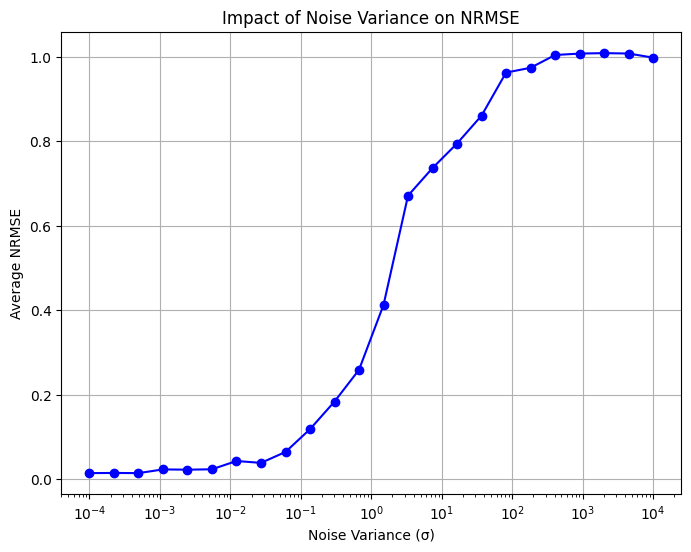

In [50]:
# Generate sigma_values dynamically using logspace
initial_order = -4  # This defines the initial value as 10^initial_order (i.e., 10^-2 = 0.01)
final_order = 4  # This defines the final value as 10^final_order (i.e., 10^6 = 1000000)
num_points_per_order = 3  # Number of points between each order of magnitude
sigma_values = np.logspace(initial_order, final_order, num=((final_order - initial_order) * num_points_per_order)) # Generate values from 10^initial_order to 10^final_order
avg_nrmse_per_sigma = []

# Analyze the impact of sigma
for sigma in sigma_values:
    # Run the experiment for the current sigma using default values for N and D
    avg_loss, _ = experiment(sigma=sigma, num_runs=5)  # Call the existing experiment function
    avg_nrmse_per_sigma.append(avg_loss)  # Store the average loss (NRMSE)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.plot(sigma_values, avg_nrmse_per_sigma, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('Noise Variance (σ)')
plt.ylabel('Average NRMSE')
plt.title('Impact of Noise Variance on NRMSE')
plt.grid(True)
plt.show()

We can clearly see two zones with a transition in the middle:
- For values less that $10^{-2}$, the error is quite small since the model is able to "ignore" the noise and learn the true weights
- From about $10^2$, the error becomes large, as the influence of the noise on the target values exceeds that of the input and weights themselves

## 10
> _Examine the impact of N and $λ_2$ on the NRMSE for linear regression using gradient descent_

N = 50, λ₂ = 0.000, Average NRMSE = 0.757
N = 50, λ₂ = 0.001, Average NRMSE = 0.384
N = 50, λ₂ = 0.018, Average NRMSE = 0.495
N = 50, λ₂ = 0.237, Average NRMSE = 0.371
N = 50, λ₂ = 3.162, Average NRMSE = 0.932
N = 188, λ₂ = 0.000, Average NRMSE = 0.314
N = 188, λ₂ = 0.001, Average NRMSE = 0.377
N = 188, λ₂ = 0.018, Average NRMSE = 0.417
N = 188, λ₂ = 0.237, Average NRMSE = 0.396
N = 188, λ₂ = 3.162, Average NRMSE = 0.792
N = 707, λ₂ = 0.000, Average NRMSE = 0.381
N = 707, λ₂ = 0.001, Average NRMSE = 0.286
N = 707, λ₂ = 0.018, Average NRMSE = 0.274
N = 707, λ₂ = 0.237, Average NRMSE = 0.357
N = 707, λ₂ = 3.162, Average NRMSE = 0.798
N = 2660, λ₂ = 0.000, Average NRMSE = 0.351
N = 2660, λ₂ = 0.001, Average NRMSE = 0.268
N = 2660, λ₂ = 0.018, Average NRMSE = 0.327
N = 2660, λ₂ = 0.237, Average NRMSE = 0.562
N = 2660, λ₂ = 3.162, Average NRMSE = 0.803
N = 10000, λ₂ = 0.000, Average NRMSE = 0.265
N = 10000, λ₂ = 0.001, Average NRMSE = 0.394
N = 10000, λ₂ = 0.018, Average NRMSE = 0.278
N = 1

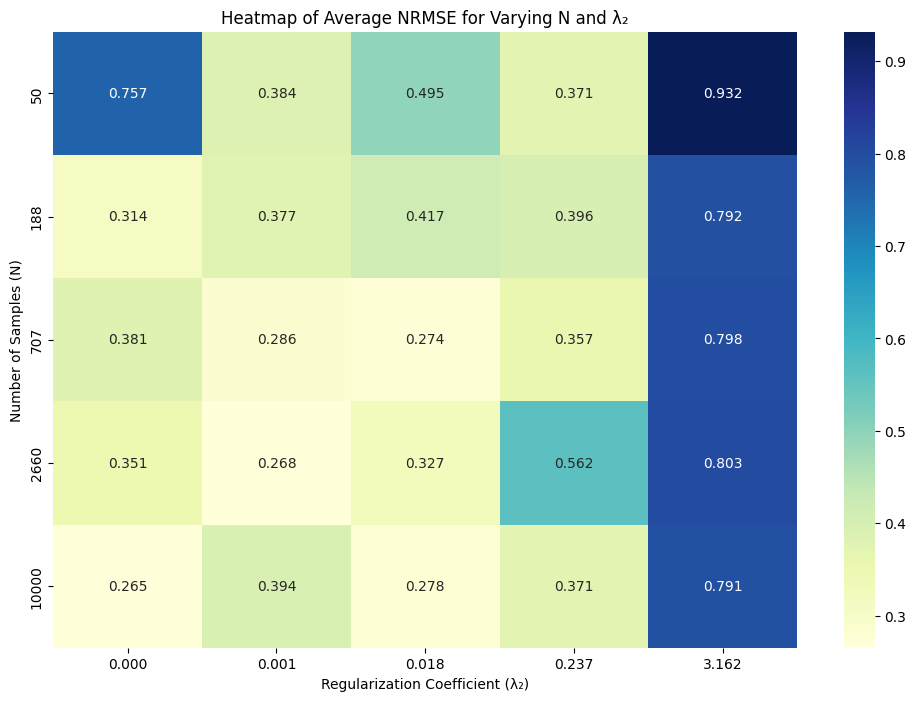

In [51]:
# Generate values for N and lambda_2 on a logarithmic scale
N_values = np.logspace(1.7, 4, 5, dtype=int)  # N values from 100 to 1000
lambda_2_values = np.logspace(-4, 0.5, 5)  # lambda_2 values from 0.001 to 10.0

# Initialize a list to store the average NRMSE for each combination
average_nrmse = np.zeros((len(N_values), len(lambda_2_values)))

# Analyze the impact of N and lambda_2
for i, N in enumerate(N_values):
    for j, lambda_2 in enumerate(lambda_2_values):
        # Run the experiment for the current combination of N and lambda_2
        avg_loss, _ = experiment(N=N, lambda_2=lambda_2)  # Call the existing experiment function
        average_nrmse[i, j] = avg_loss  # Store the average NRMSE
        print(f"N = {N}, λ₂ = {lambda_2:.3f}, Average NRMSE = {avg_loss:.3f}")

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(average_nrmse, annot=True, fmt=".3f", cmap='YlGnBu', 
            xticklabels=[f'{l:.3f}' for l in lambda_2_values], 
            yticklabels=N_values)
plt.xlabel('Regularization Coefficient (λ₂)')
plt.ylabel('Number of Samples (N)')
plt.title('Heatmap of Average NRMSE for Varying N and λ₂')
plt.show()

## 11
> _Examine the impact of $λ_1$ value pair on variable elimination. for a fixed generator matrix G. Introduce correlations in the columns of X and repeat the experiment._

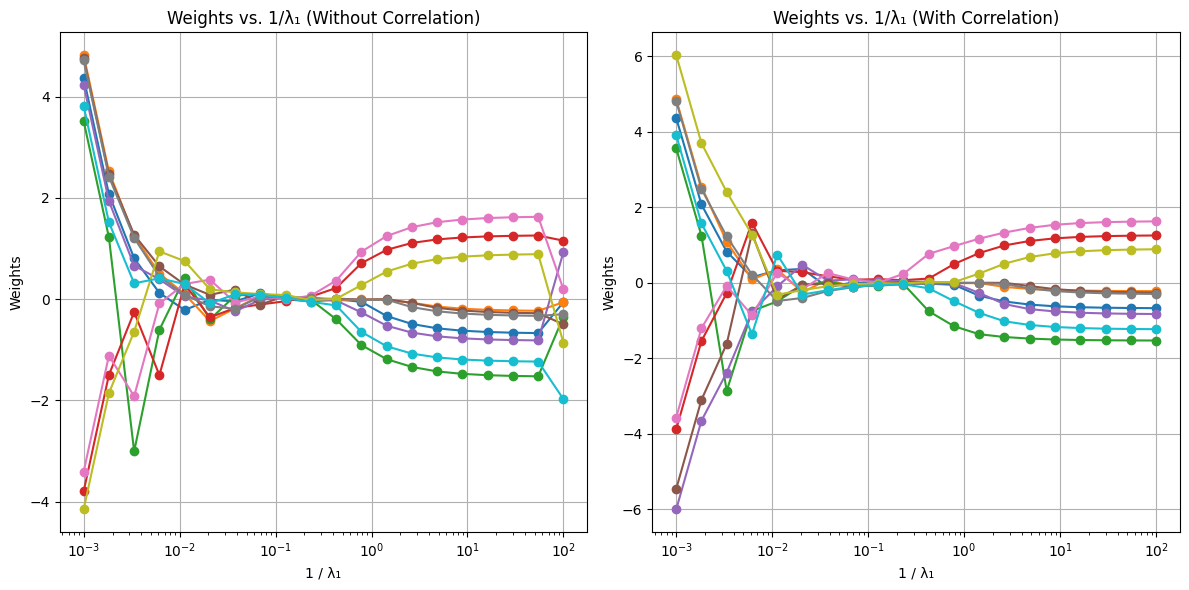

In [52]:
# Parameters for the analysis
D = 10  # Number of features
lambda_1_values = np.logspace(-2, 3, 20)  # λ1 values from 0.001 to 10.0
X_seed = 2  # Seed for reproducibility
correlation_strength = 0.5  # Define correlation strength

# Prepare to store weights without correlation
weights_without_corr = []

# Calculate weights for different λ1 values without correlation
for lambda_1 in lambda_1_values:
    avg_loss, w_final = experiment(D=D,lambda_1=lambda_1, X_seed=X_seed)  # Use identity matrix for uncorrelated data
    weights_without_corr.append(w_final[1:].flatten())  # Store only weights without bias


# Prepare to store weights with correlation
weights_with_corr = []

# Create a zero matrix for the correlation mask
correlation_mask = np.zeros((D, D))

# Define correlation structure
correlation_mask[0, 0] = 1  # Feature 1
correlation_mask[1:3, 1:3] = 1  # Features 2 and 3
correlation_mask[3:7, 3:7] = 1  # Features 4 to 7
correlation_mask[7:, 7:] = 1  # Remaining features

# Retain upper triangular part to avoid redundancy
correlation_mask = np.triu(correlation_mask, k=1)
np.fill_diagonal(correlation_mask, 1) # Fill diagonal with 1s, for the next step

# Create the final correlation matrix
correlation_strength = 0.5  # Desired correlation strength
G = (1 - correlation_strength) * np.eye(D) + correlation_strength * correlation_mask


# Calculate weights for different λ1 values with correlation
for lambda_1 in lambda_1_values:
    avg_loss, w_final = experiment(D=D,lambda_1=lambda_1, G=G, X_seed=X_seed)  # Use correlated generator matrix
    weights_with_corr.append(w_final[1:].flatten())  # Store only weights without bias

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot without correlation
plt.subplot(1, 2, 1)
plt.plot(1 / lambda_1_values, np.array(weights_without_corr), marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('1 / λ₁')
plt.ylabel('Weights')
plt.title('Weights vs. 1/λ₁ (Without Correlation)')
plt.grid(True)

# Plot with correlation
plt.subplot(1, 2, 2)
plt.plot(1 / lambda_1_values, np.array(weights_with_corr), marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('1 / λ₁')
plt.ylabel('Weights')
plt.title('Weights vs. 1/λ₁ (With Correlation)')
plt.grid(True)

plt.tight_layout()
plt.show()


## 12
> _Show the grouping effect of elastic net on correlated columns of X_

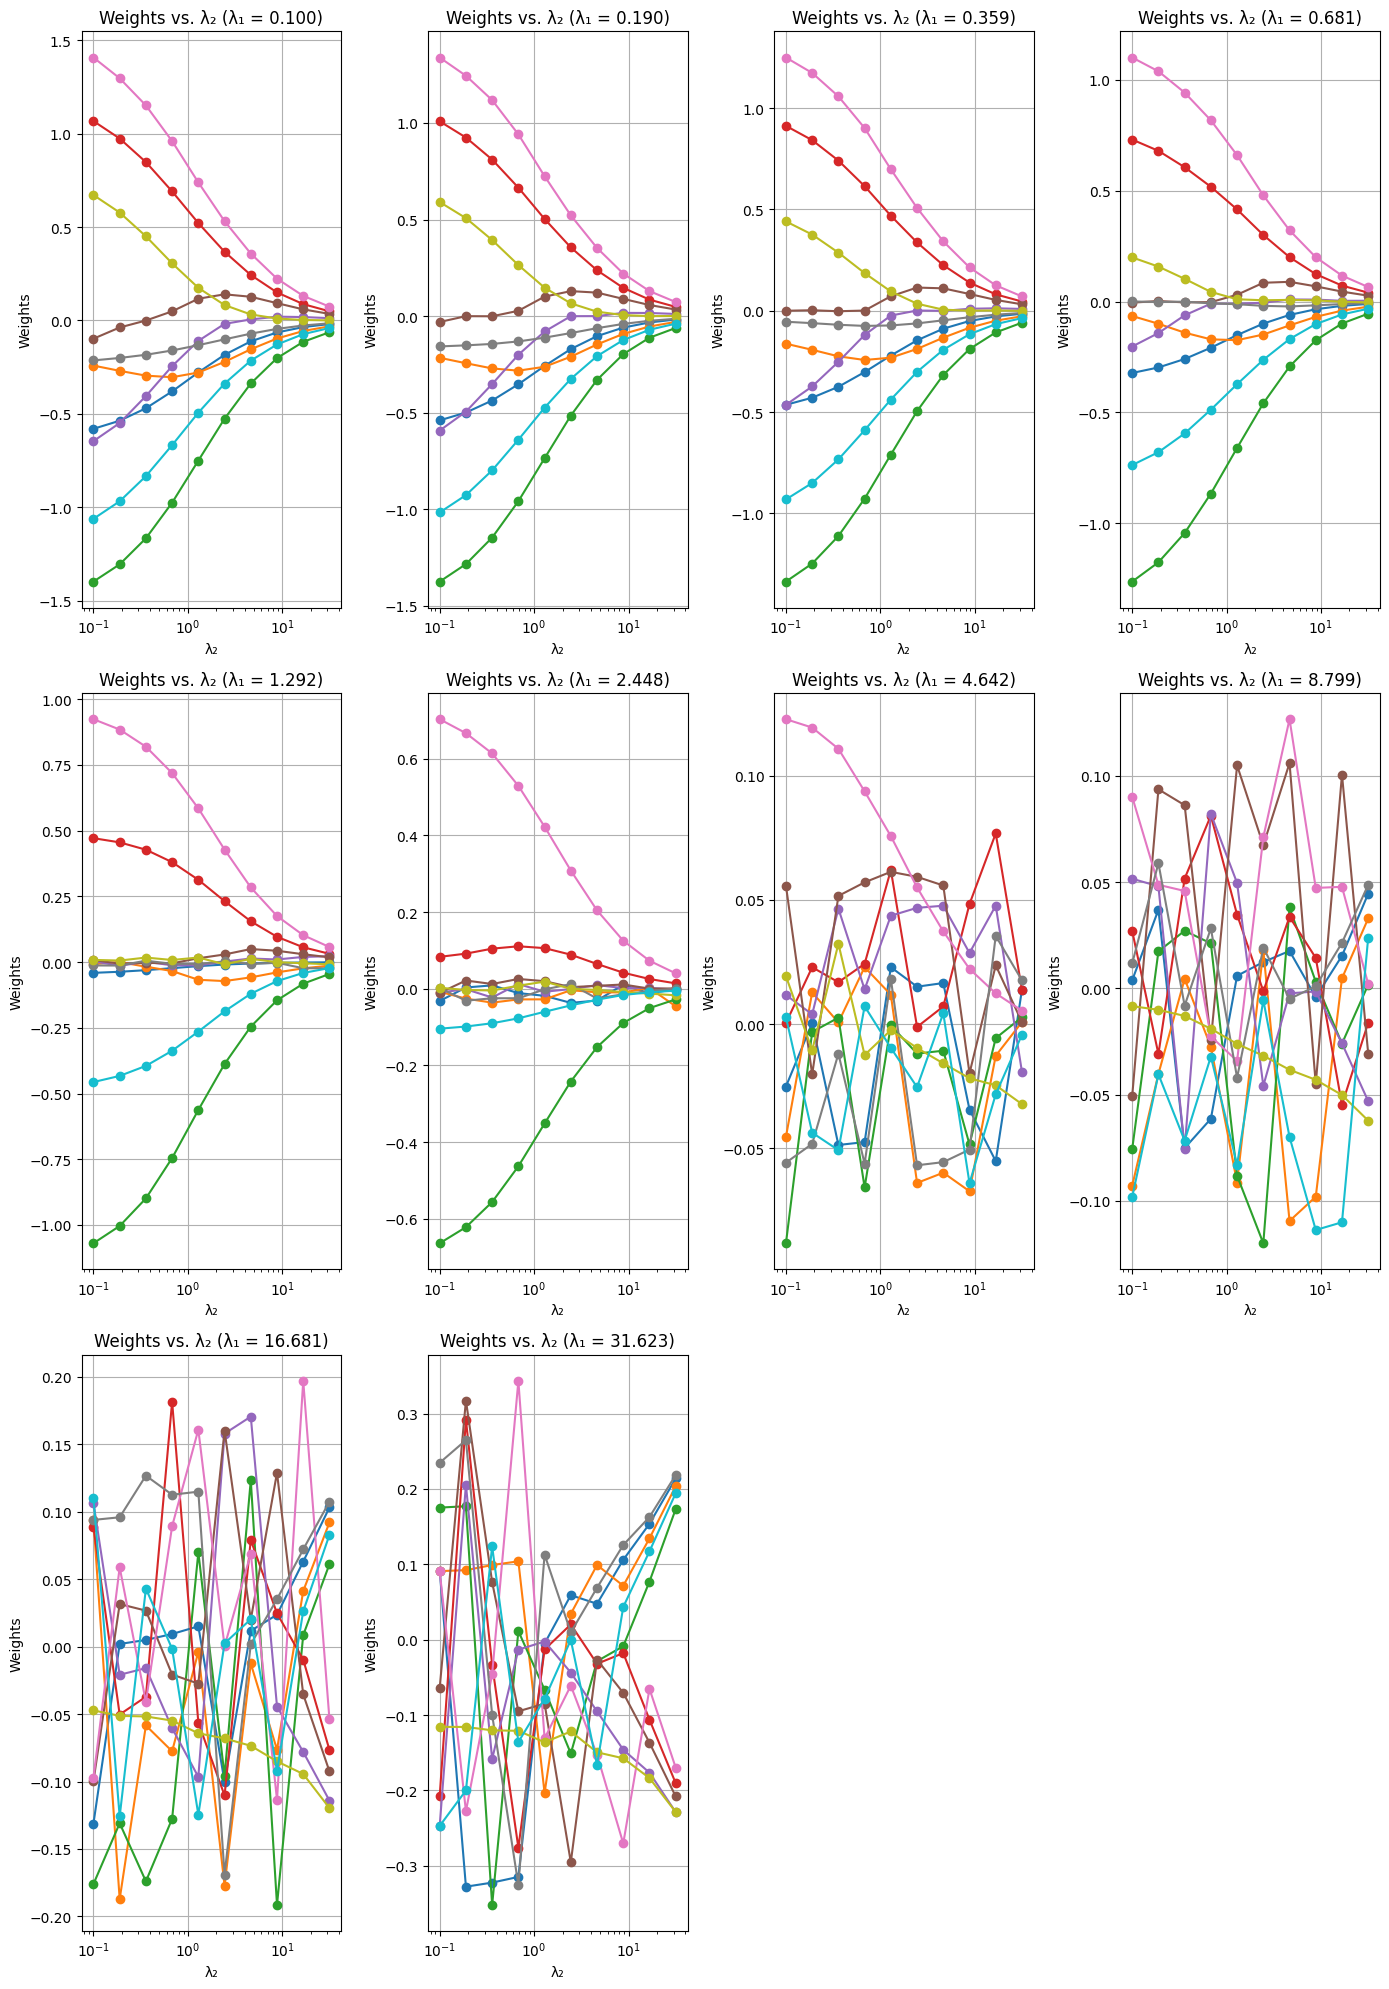

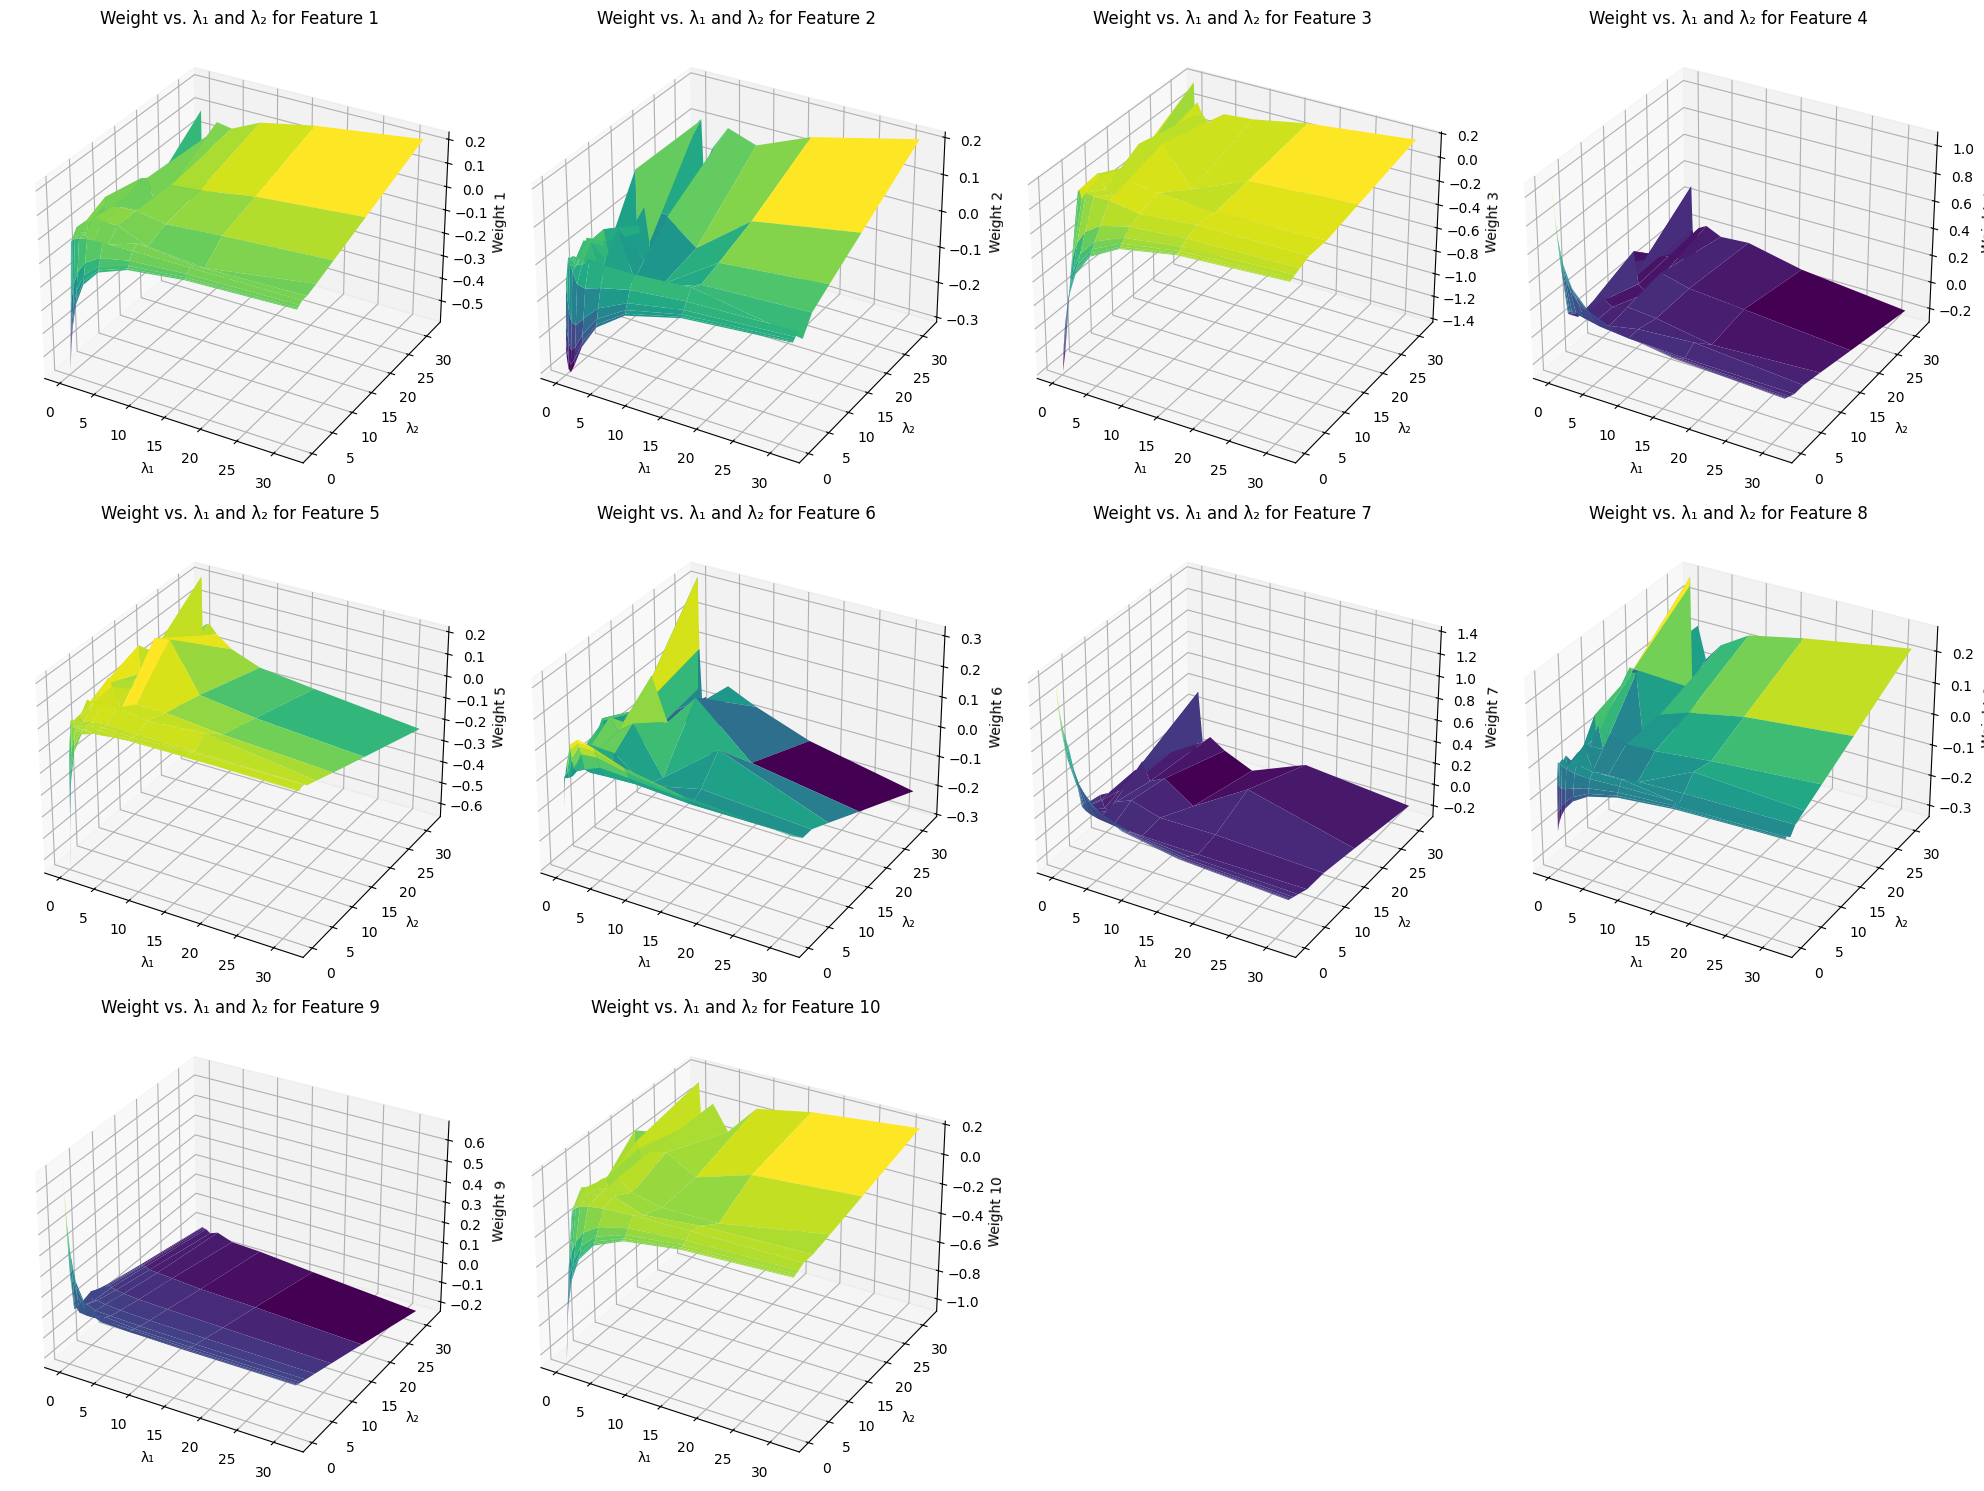

In [53]:
# Parameters for the analysis
D = 10  # Number of features
lambda_1_values = np.logspace(-1, 1.5, 10)  # λ1 values from 0.001 to 10.0
lambda_2_values = np.logspace(-1, 1.5, 10)  # λ2 values from 0.001 to 10.0
X_seed = 2  # Seed for reproducibility
correlation_strength = 0.5  # Define correlation strength


# Create a zero matrix for the correlation mask
correlation_mask = np.zeros((D, D))

# Define correlation structure
correlation_mask[0, 0] = 1  # Feature 1
correlation_mask[1:3, 1:3] = 1  # Features 2 and 3
correlation_mask[3:7, 3:7] = 1  # Features 4 to 7
correlation_mask[7:, 7:] = 1  # Remaining features

# Retain upper triangular part to avoid redundancy
correlation_mask = np.triu(correlation_mask, k=1)
np.fill_diagonal(correlation_mask, 1) # Fill diagonal with 1s, for the next step

# Create the final correlation matrix
G = (1 - correlation_strength) * np.eye(D) + correlation_strength * correlation_mask

# Prepare to store weights for each combination of λ1 and λ2
weights = np.zeros((len(lambda_1_values), len(lambda_2_values), D))  # 3D array to hold weights

# Run the experiment for different λ1 and λ2 values
for i, lambda_1 in enumerate(lambda_1_values):
    for j, lambda_2 in enumerate(lambda_2_values):
        avg_loss, w_final = experiment(D=D, lambda_1=lambda_1, lambda_2=lambda_2, G=G, X_seed=X_seed)  # Use identity for correlated case
        weights[i, j] = w_final[1:].flatten()  # Store weights without bias

# Plotting the results
plt.figure(figsize=(14, 20))

# Create subplots for each λ1 value
for i, lambda_1 in enumerate(lambda_1_values):
    plt.subplot(3, 4, i + 1)
    plt.plot(lambda_2_values, weights[i], marker='o')
    plt.xscale('log')
    plt.title(f'Weights vs. λ₂ (λ₁ = {lambda_1:.3f})')
    plt.xlabel('λ₂')
    plt.ylabel('Weights')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Generated by [8]
# Plot a 3D surface plot for the weights of all D features
fig = plt.figure(figsize=(20, 15))

# Create a meshgrid for λ1 and λ2 values
L1, L2 = np.meshgrid(lambda_1_values, lambda_2_values)

# Plot the 3D surface for each feature
for d in range(D):
    ax = fig.add_subplot(3, 4, d + 1, projection='3d')
    ax.plot_surface(L1, L2, weights[:, :, d], cmap='viridis')
    ax.set_xlabel('λ₁')
    ax.set_ylabel('λ₂')
    ax.set_zlabel(f'Weight {d+1}')
    ax.set_title(f'Weight vs. λ₁ and λ₂ for Feature {d+1}')

plt.tight_layout()
plt.show()

From the 3D graphs one can observe that for the most part, correlated features (2-3,4-7,8-10) seem to have similar trends.

## 13
> _Write a function for generating linear binary classification vector t with noise variance σ._

In [54]:
def sigmoid(x):
    """Compute the sigmoid function."""
    sigm = 1 / (1 + np.exp(-x.flatten()))
    return sigm.reshape(-1, 1)

In [55]:
def generate_binary_classification_vector(X, w, sigma):
    """
    Generate a binary classification target vector t of size Nx1 with noise variance σ.
    
    Parameters
    ----------
    X : numpy.ndarray
        Data matrix of size NxD.
    w : numpy.ndarray
        Weight vector of size D+1 (includes bias term) in 1D or 2D.
    sigma : float
        Noise variance for adding Gaussian noise.
    
    Returns
    -------
    t : numpy.ndarray
        Binary classification target vector of size Nx1 (0s and 1s).
    """
    # Use the existing function to generate the target vector
    t = generate_target_vector(X, w, sigma)

    # Apply the sigmoid function to convert to probabilities
    probabilities = sigmoid(t)  # Flatten to 1D for sigmoid

    # Convert probabilities to binary labels (0 or 1)
    t = (probabilities > 0.5).astype(int)  # Threshold at 0.5

    return t


#### Test

In [56]:
def test_generate_binary_classification_vector():
    """
    Test cases for the generate_binary_classification_vector function.
    """
    # Test parameters
    N = 1000  # Number of samples
    D = 5     # Number of features
    w_true = np.random.randn(D + 1, 1)  # True weights including bias
    sigma = 0.1  # Noise variance

    # Generate a random data matrix X
    X = np.random.randn(N, D)

    # Test 1: Check shape of output vector
    t = generate_binary_classification_vector(X, w_true, sigma)
    assert t.shape == (N, 1), f"Test 1 Failed: Expected shape {(N, 1)}, but got {t.shape}"

    # Test 2: Check values are binary (0s and 1s)
    unique_values = np.unique(t)
    assert np.array_equal(unique_values, np.array([0, 1])), f"Test 2 Failed: Expected binary output, but got {unique_values.flatten()}"

    # Test 3: Check for dimensionality mismatch
    try:
        generate_binary_classification_vector(X, np.random.randn(D, 1), sigma)
        assert False, "Test 3 Failed: Expected ValueError due to dimension mismatch, but no error was raised."
    except ValueError as e:
        assert str(e) == "Dimension mismatch: X has 5 columns, but w has 5 elements. w should have 6 elements."

    print("All test cases passed!")

# Run the test function
test_generate_binary_classification_vector()


All test cases passed!


## 14
> _Write a function for computing gradient of binary cross-entropy for logistic regression_

In [57]:
def binary_cross_entropy_gradient(y, t, X):
    """
    Compute the gradient of the binary cross-entropy loss for logistic regression.
    
    Parameters
    ----------
    y : numpy.ndarray
        Predicted probabilities of size Nx1.
    t : numpy.ndarray
        True binary labels of size Nx1.
    X : numpy.ndarray
        Data matrix of size NxD.
    
    Returns
    -------
    gradient : numpy.ndarray
        Gradient of the binary cross-entropy loss with respect to the weights.
    """
    # Ensure t and y are the same shape
    if t.shape != y.shape:
        raise ValueError(f"Dimension mismatch: t has shape {t.shape}, but y has shape {y.shape}.")

    # Compute the gradient
    gradient = -np.dot(X.T, (t - y)) / len(t)  # Average gradient

    # Suggestions from [9]
    bias_gradient = np.mean(y - t)  # Gradient for the bias term
    # bias_gradient = 
    return np.vstack((bias_gradient,gradient))


#### Test

In [58]:
def test_binary_cross_entropy_gradient():
    """
    Test cases for the binary_cross_entropy_gradient function.
    """
    # Test parameters
    N = 5  # Number of samples
    D = 3  # Number of features

    # Test 1: Simple case with known values
    t = np.array([[1], [0], [1], [0], [1]])  # True labels
    y = np.array([[0.9], [0.1], [0.8], [0.2], [0.6]])  # Predicted probabilities
    X = np.random.randn(N, D)  # Random data matrix for inputs

    # Calculate expected gradient
    expected_gradient = np.vstack((
        np.mean(y - t),  # Bias gradient
        -np.dot(X.T, (t - y)) / N  # Weights gradient
    ))
    
    # Compute the actual gradient using the function
    grad = binary_cross_entropy_gradient(y, t, X)
    
    # Check if the computed gradient matches the expected gradient
    assert np.allclose(grad, expected_gradient), f"Test 1 Failed: Expected {expected_gradient}, but got {grad}"

    # Test 2: Check shape of output gradient
    t = np.random.randint(0, 2, size=(N, 1))  # Random binary labels
    y = np.random.rand(N, 1)  # Random predicted probabilities
    X = np.random.randn(N, D)  # Random data matrix
    grad = binary_cross_entropy_gradient(y, t, X)
    
    # The gradient should have D + 1 rows (D for weights and 1 for bias)
    assert grad.shape == (D + 1, 1), f"Test 2 Failed: Expected gradient shape {(D + 1, 1)}, but got {grad.shape}"

    # Test 3: Check for dimension mismatch
    try:
        binary_cross_entropy_gradient(y.flatten(), t, X)  # Incorrect shape for y
        assert False, "Test 3 Failed: Expected ValueError due to dimension mismatch, but no error was raised."
    except ValueError as e:
        assert str(e) == f"Dimension mismatch: t has shape {(N, 1)}, but y has shape {(N,)}."

    # Test 4: Check behavior with edge probabilities
    t = np.array([[1], [0]])  # True labels for edge cases
    y = np.array([[1e-10], [1 - 1e-10]])  # Predicted probabilities near 0 and 1
    X = np.random.randn(2, D)  # Random data matrix for edge case
    grad = binary_cross_entropy_gradient(y, t, X)
    
    # Calculate expected gradient for this edge case
    expected_grad = np.vstack((
        np.mean(y - t),  # Bias gradient
        -np.dot(X.T, (t - y)) / 2  # Weights gradient
    ))
    
    assert np.allclose(grad, expected_grad), f"Test 4 Failed: Expected {expected_grad}, but got {grad}"

    print("All test cases passed!")

# Run the test function
test_binary_cross_entropy_gradient()


All test cases passed!


## 15
> _Repeat experiment 10 for binary classification._

In [59]:
def gradient_descent(X, t, w_init, lambda_1, lambda_2, learning_rate=0.01, max_iter=1000, tol=1e-6, loss_queue_length=100, print_level=1):
    """
    Perform gradient descent to minimize binary cross-entropy + λ1*L1 + λ2*L2 with bias handling.
    """
    w = w_init.copy()
    N, D = X.shape
    
    # Use deque to store a fixed number of recent losses
    losses = deque(maxlen=loss_queue_length)

    for iteration in range(max_iter):
        # Compute predictions including bias (first term of w)
        y = sigmoid(np.dot(X, w[1:]) + w[0])  # Apply sigmoid to get probabilities

        # Compute the gradient of binary cross-entropy
        bce_grad = binary_cross_entropy_gradient(y, t, X)

        # Compute the gradients of L1 and L2 norms (bias is not regularized)
        l1_grad = lambda_1 * l1_gradient(w)
        l2_grad = lambda_2 * l2_gradient(w)

        # Combine the gradients
        total_grad = (bce_grad + l1_grad + l2_grad)

        # Update weights (bias should not be affected by regularization)
        w_new = w - learning_rate * total_grad

        # Compute the loss (binary cross-entropy + λ1*L1 + λ2*L2, excluding bias from L1/L2 loss)
        clipped_y = np.clip(y, 1e-10, 1 - 1e-10)  # Clip to avoid log(0)
        bce_loss = -np.mean(t * np.log(clipped_y) + (1 - t) * np.log(1 - clipped_y))
        l1_loss = lambda_1 * np.sum(np.abs(w[1:]))  # Exclude bias from L1 regularization
        l2_loss = lambda_2 * np.sum(w[1:] ** 2)      # Exclude bias from L2 regularization

        total_loss = bce_loss + l1_loss + l2_loss
        
        # Append the loss to the deque
        losses.append(total_loss)

        # Stopping criterion: if the change in weights is smaller than the tolerance
        if print_level > 0 and np.linalg.norm(w_new - w) < tol:
            print(f"Convergence reached after {iteration + 1} iterations.")
            break

        # Print the change in weights every 50 iterations
        if print_level > 1 and iteration % 50 == 0:
            print(f"Iteration {iteration}: Change in weights = {np.linalg.norm(w_new - w)}")

        w = w_new

    return w, losses


In [68]:
# Generated by [10]
def normalized_binary_cross_entropy(t, y):
    """
    Compute the normalized binary cross-entropy loss for binary classification.
    
    Parameters
    ----------
    t : numpy.ndarray
        True binary labels of size Nx1.
    y : numpy.ndarray
        Predicted probabilities of size Nx1.
    
    Returns
    -------
    loss : float
        Normalized binary cross-entropy loss.
    """
    # Ensure t and y are the same shape
    if t.shape != y.shape:
        raise ValueError(f"Dimension mismatch: t has shape {t.shape}, but y has shape {y.shape}.")

    # Clip the predicted probabilities to avoid log(0) and log(1)
    clipped_y = np.clip(y, 1e-10, 1 - 1e-10)

    # Compute the binary cross-entropy loss
    bce_loss = -np.mean(t * np.log(clipped_y) + (1 - t) * np.log(1 - clipped_y))

    return bce_loss

N = 50, λ₂ = 0.000, Average NRMSE = 6.564, Average NBCE = -41.627
N = 50, λ₂ = 0.001, Average NRMSE = 7.082, Average NBCE = -37.954
N = 50, λ₂ = 0.018, Average NRMSE = 11.277, Average NBCE = -38.482
N = 50, λ₂ = 0.237, Average NRMSE = 5.900, Average NBCE = -31.512
N = 50, λ₂ = 3.162, Average NRMSE = 1.377, Average NBCE = -1.265
N = 188, λ₂ = 0.000, Average NRMSE = 5.818, Average NBCE = -9.248
N = 188, λ₂ = 0.001, Average NRMSE = 7.082, Average NBCE = -49.898
N = 188, λ₂ = 0.018, Average NRMSE = 7.928, Average NBCE = -58.431
N = 188, λ₂ = 0.237, Average NRMSE = 1.396, Average NBCE = -57.941
N = 188, λ₂ = 3.162, Average NRMSE = 0.974, Average NBCE = -2.568
N = 707, λ₂ = 0.000, Average NRMSE = 8.881, Average NBCE = -42.929
N = 707, λ₂ = 0.001, Average NRMSE = 7.249, Average NBCE = -32.929
N = 707, λ₂ = 0.018, Average NRMSE = 7.238, Average NBCE = -70.230
N = 707, λ₂ = 0.237, Average NRMSE = 1.340, Average NBCE = -60.432
N = 707, λ₂ = 3.162, Average NRMSE = 2.557, Average NBCE = -19.195
N 

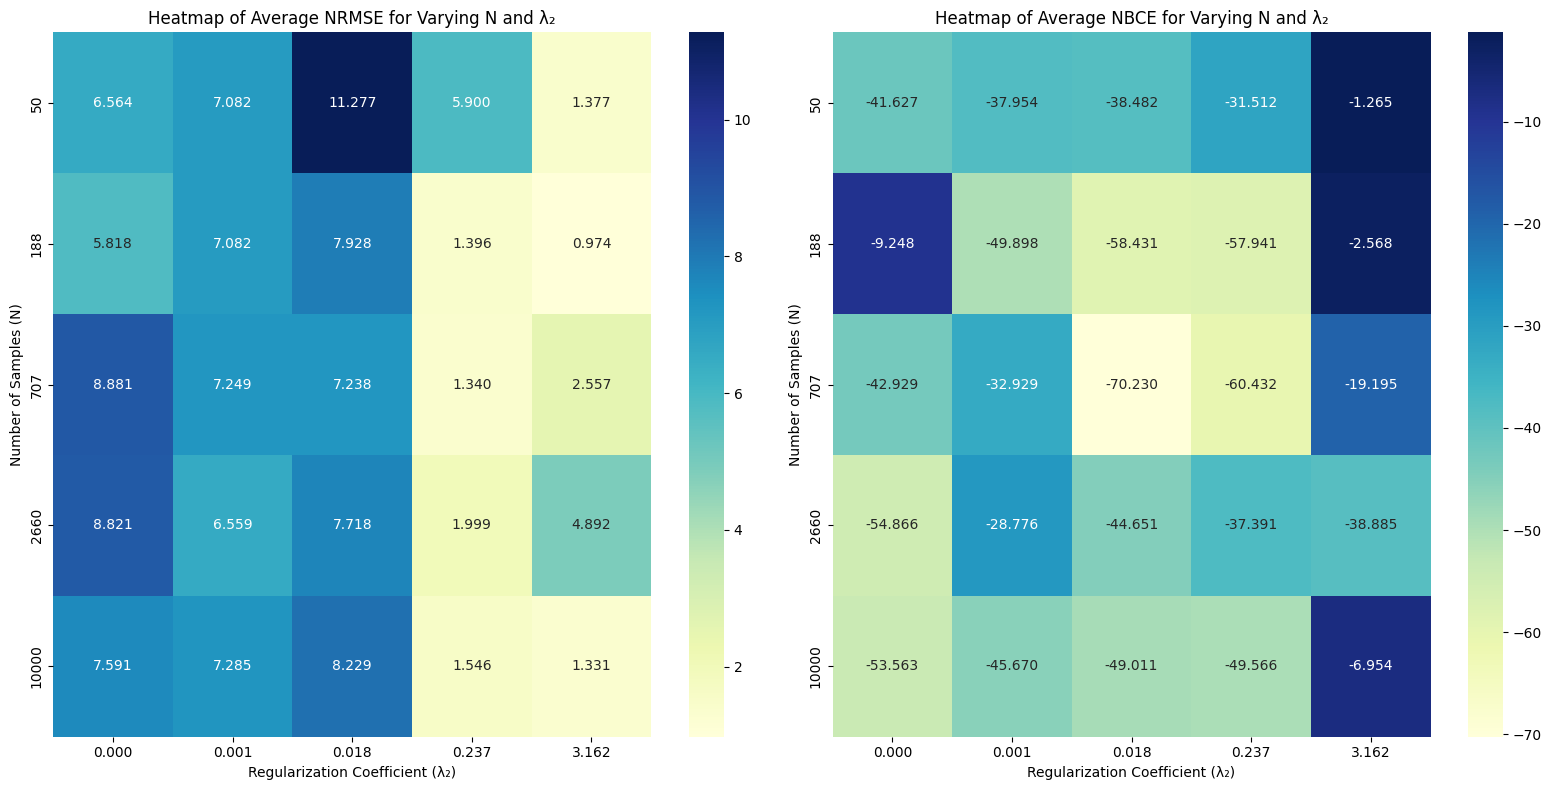

In [69]:
# Generate values for N and lambda_2 on a logarithmic scale
N_values = np.logspace(1.7, 4, 5, dtype=int)  # N values from 100 to 1000
lambda_2_values = np.logspace(-4, 0.5, 5)  # lambda_2 values from 0.001 to 10.0

# Initialize a list to store the average NRMSE for each combination
average_nrmse = np.zeros((len(N_values), len(lambda_2_values)))
average_nbce = np.zeros((len(N_values), len(lambda_2_values)))

# Analyze the impact of N and lambda_2
for i, N in enumerate(N_values):
    for j, lambda_2 in enumerate(lambda_2_values):
        # Run the experiment for the current combination of N and lambda_2
        avg_loss, weights, avg_bce_loss = experiment(N=N, lambda_2=lambda_2, custom_loss=normalized_binary_cross_entropy)  # Call the existing experiment function
        average_nrmse[i, j] = avg_loss  # Store the average NRMSE
        average_nbce[i, j] = avg_bce_loss # Store the average NBCE

        # Calculate NBCE loss usin
        print(f"N = {N}, λ₂ = {lambda_2:.3f}, Average NRMSE = {avg_loss:.3f}, Average NBCE = {avg_bce_loss:.3f}")

# Plotting the heatmaps
plt.figure(figsize=(16, 8))

# Heatmap for Average NRMSE
plt.subplot(1, 2, 1)
sns.heatmap(average_nrmse, annot=True, fmt=".3f", cmap='YlGnBu', 
            xticklabels=[f'{l:.3f}' for l in lambda_2_values], 
            yticklabels=N_values)
plt.xlabel('Regularization Coefficient (λ₂)')
plt.ylabel('Number of Samples (N)')
plt.title('Heatmap of Average NRMSE for Varying N and λ₂')

# Heatmap for Average NBCE
plt.subplot(1, 2, 2)
sns.heatmap(average_nbce, annot=True, fmt=".3f", cmap='YlGnBu', 
            xticklabels=[f'{l:.3f}' for l in lambda_2_values], 
            yticklabels=N_values)
plt.xlabel('Regularization Coefficient (λ₂)')
plt.ylabel('Number of Samples (N)')
plt.title('Heatmap of Average NBCE for Varying N and λ₂')

plt.tight_layout()
plt.show()



## Attributions

0. ChatGPT prompt  
   Add docstrings and necessary comments to this code-block. Suggest any changes or mistakes that you observe in the code too.
1. ChatGPT prompt  
Provide me with descriptions of why I am using the following libraries in my data analysis assignment, in Markdown:
    ```
    import matplotlib.pyplot as plt
    import numpy as np
    ```
1. ChatGPT prompt:  
   Would it be possible to write a test case for this? (Code appended)
1. ChatGPT prompt:  
   Want to easily add more values to N_values, by specifying order of final values
1. ChatGPT prompt:  
   What would be a good stopping criterion for this? (partially complete code attached)
1. ChatGPT prompt:  
   Is there a better alternative to a list, in the cases where my number of iterations becomes very large?
2. ChatGPT prompt:  
   I would like you to make the experiment function such that it just averages the loss and weight values and outputs them for a given set of hyper-parameters, since further parts will also explore similar experiments which vary different hyper-parameters. (Bodies of the later bits also provided, excluded for brevity)
7. ChatGPT prompt:  
   This is what I've tried to use to generate a correlated matrix with correlation strength G, but it adds correlations between all the variables equally

        S = np.full((D, D), G) + np.eye(D) * (1 - G)
7. ChatGPT prompt:  
   How can I plot the weights for each feature in 3D?
1. ChatGPT prompt:  
   How can I account for the bias in BCE loss?
1. ChatGPT prompt:  
   How can I normalize BCE loss?